# Cancer Detection and Data background

The project involves building CNN classifiers from scratch to detect cancer cells in images. The competition focuses on finding a single cancerous cell in a 32x32 square at the center of each image, making it very challenging. Since there is no competition here (it is over), the classifiers will label the entire image as malignant or benign. This simplifies the training process.

The notebook will explore a few CNN iterations. Different activation functions, layers, and hyperparameters will be tested.

The curated Kaggle dataset will be used, available [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). This dataset, provided by Bas Veeling and others, has removed duplicate images and is hosted by Kaggle for practice. The original dataset can be found on [GitHub](https://github.com/basveeling/pcam) under the CC0 License. 


In [ ]:
# for stability, set the version of tensorflow
#!pip install wurlitzer
#!pip install tensorflow==2.13.0
#!pip install tensorflow[and-cuda]
#!pip install tensorflow-io

In [ ]:
# Standard Kaggle info


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf 
# the below is needed to fix cuDNN registration issues, put immediately after the tf import
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_io as tfio

import numpy as np 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import AvgPool2D,BatchNormalization, Conv2D, Dense, Flatten, Input, GlobalAveragePooling2D, Dropout 
from keras.layers import MaxPool2D, MaxPooling2D, ReLU, concatenate
import math, gc, copy

AUTOTUNE = tf.data.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')
import os

print("Tensorflow Version In Use: ", tf.__version__ )

Tensorflow Version In Use:  2.15.0


Next, we detect our hardware and light up GPUs or TPUs if we have them.

In [3]:
# Detect hardware and GPUs/TPUs (useful code here is copied from code search, not original)
try:
     # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    # instantiate a distribution strategy
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
 
    # report results
    print('Running on TPU ', tpu.cluster_spec().as_dict())

except ValueError: # If TPU not found
    tpu = None
    tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
    print('Running on CPU instead')

print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)
print("TPU: ", tpu)

Running on CPU instead
Number of accelerators:  1
TPU:  None


In [4]:
gpus = tf.config.list_physical_devices('GPU')
try:
    if gpus:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


# Load Data

Load data and show basic information to describe the data files.

In [5]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# get basic info
print(df.info())
print('')
print(df.describe())
print('')

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000



,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Of the 220 thousand rows of data, 40% of the observations have a positive cancer label (mean of the binary 1 over the count). The labels iare binary (1,0) with no null values in either column.

Analysis of the counts by the classification lables show an imbalance in the data.  Most are negative (no cancer/benign).  

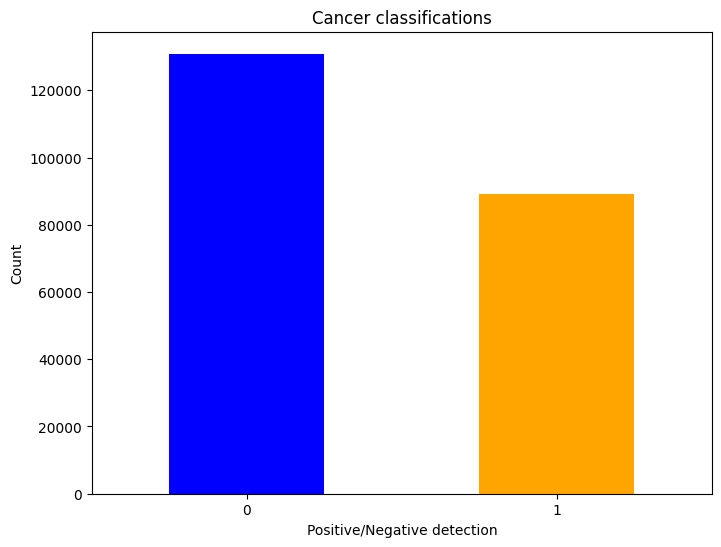

In [6]:
# Count the occurrences of each category
category_counts = df['label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Cancer classifications')
plt.xlabel('Positive/Negative detection')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
imagelist = os.listdir('/kaggle/input/histopathologic-cancer-detection/train')
print("Image List length:", len(imagelist))

print ("Image list type:", type(imagelist))
print ("First record type: ", type(imagelist[0]))
print ("First image values: ", imagelist[0])

Image List length: 220025
Image list type: <class 'list'>
First record type:  <class 'str'>
First image values:  d43c081bafa286f9c1f7e921883f26ceafebc912.tif


The number of rows match the number of images in the training folder. Raw data is shown, the file contains the image file name.

In [8]:
# Load sample submission data

dfss = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
# describe data
print(dfss.describe())
print('')
print(dfss.info())
print('')

imagesslist = os.listdir('/kaggle/input/histopathologic-cancer-detection/test/')
print("Validation Image List length:", len(imagesslist))

# raw data
dfss.head()

         label
count  57458.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
None

Validation Image List length: 57458


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


The validation set has no labels, all are 0.

In [ ]:
fig, axs = plt.subplots(3,4) 
col = 0
row = 0
for i in range(12):
    imid = df.id.sample(1).values[0]
    image = Image.open('/kaggle/input/histopathologic-cancer-detection/train/'+imid+'.tif')
    axs[col,row].imshow(image)
    if col == 2:
        row +=1
        col = 0
    else:
        col +=1
plt.show();
print("Image Specifications: Shape",image.size,"\nFormat:",image.info )


## Data handling in preperation for modeling
Preprocess data to better balance the data set

In [11]:
randomseed = 9

# rebalance so classes of positive and negative are same size, this will help in improving classification training
trainsize = int(df.label.sum() * .7)
testsize = df.label.sum()-trainsize
cancer = pd.DataFrame(df.index[df['label'] ==1].tolist(),columns=['id'])
negative = pd.DataFrame(df.index[df['label'] ==0].tolist(),columns=['id'])

# random sample the split
cancer_train = cancer['id'].sample(trainsize,replace=False,random_state = randomseed)
negative_train = negative['id'].sample(trainsize,replace=False,random_state = randomseed)

print("Cancer train size:",len(cancer_train))
print("Negative train size:",len(negative_train))

Cancer train size: 62381
Negative train size: 62381


In [12]:
# mark which rows to use for train and for test
cancer['train'] = 0
negative['train'] = 0
cancer['test'] = 0
negative['test'] = 0

for i in range(len(cancer_train)):
    cancer['train'].loc[cancer['id'] == cancer_train.iat[i]] = 1
    negative['train'].loc[negative['id'] == negative_train.iat[i]] = 1

# test set samplinig
cancer_test = cancer['id'].loc[cancer['train']==0].sample(testsize,\
                                    replace=False,random_state=randomseed)
negative_test = negative['id'].loc[negative['train']==0].sample(testsize,\
                                    replace=False,random_state=randomseed)

for i in range(len(cancer_test)):
    cancer['test'].loc[cancer['id'] == cancer_test.iat[i]] ==1
    negative['test'].loc[negative['id'] == negative_test.iat[i]] ==1

# compare the test size counts
print("Cancer test size:",len(cancer_test))
print("Negative test size:",len(negative_test))

Cancer test size: 26736
Negative test size: 26736


The index numbers were used to randomly select train/test sets with balanced classes.
The dataframes for the train and test set will be built, complete with image paths.

In [13]:
def image_path(id_filename):
    return f"/kaggle/input/histopathologic-cancer-detection/train/{id_filename}.tif"

In [14]:
cancer_train_df = df.loc[df.index[cancer_train.tolist()]]
negative_train_df = df.loc[df.index[negative_train.tolist()]]

train_df = pd.concat([cancer_train_df, negative_train_df])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1, random_state=randomseed).reset_index(drop=True)

train_df['path'] = train_df.id.apply(image_path)
print("Combined train length:",len(train_df.id)," Cancer positives:",train_df.label.sum())
train_df.head()

Combined train length: 124762  Cancer positives: 62381


,id,label,path
0,610ee004e806c0f1634203b82b040d4a87fc92fb,0,/kaggle/input/histopathologic-cancer-detection...
1,c8d91cd6b64533814fac9061895e107fe7a2c60d,1,/kaggle/input/histopathologic-cancer-detection...
2,23538aaf454c3a74340e8c8afbe6db2c60f8658e,0,/kaggle/input/histopathologic-cancer-detection...
3,c943d716d4d0464658f84f350b4f6073f852d955,0,/kaggle/input/histopathologic-cancer-detection...
4,fe382865c933a9715a744dcd1c68e57fe84ea27e,0,/kaggle/input/histopathologic-cancer-detection...


In [15]:
# do same for test data
cancer_test_df = df.loc[df.index[cancer_test.tolist()]]
negative_test_df = df.loc[df.index[negative_test.tolist()]]

test_df = pd.concat([cancer_test_df, negative_test_df])
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=randomseed).reset_index(drop=True)

test_df['path'] = test_df.id.apply(image_path)
print("Combined test length:",len(test_df.id)," Cancer positives:",test_df.label.sum())
test_df.head()

Combined test length: 53472  Cancer positives: 26736


,id,label,path
0,bc7513b2dcde00b41ba4b8649078866f594adf68,0,/kaggle/input/histopathologic-cancer-detection...
1,0a9d48d78e68e0a40965d7d4ff755a2cbe26e7d1,1,/kaggle/input/histopathologic-cancer-detection...
2,f63be33a4807a5a7b568efcc3d32abc63157e963,1,/kaggle/input/histopathologic-cancer-detection...
3,658d57f1b3d309cec1dd589b05adc167fd8cdc87,1,/kaggle/input/histopathologic-cancer-detection...
4,157a4a7600af7d458faf66902ecc259c58600105,1,/kaggle/input/histopathologic-cancer-detection...


Turn dataframes into numpy arrays for the cnn training

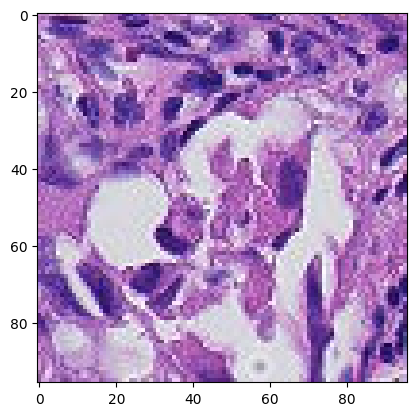

tf.Tensor(
[[[0.79215693 0.5803922  0.8235295 ]
  [0.7568628  0.5529412  0.7960785 ]
  [0.7490196  0.5529412  0.7843138 ]
  [0.86274517 0.6745098  0.90196085]
  [0.8431373  0.65882355 0.8745099 ]]

 [[0.69411767 0.47058827 0.7372549 ]
  [0.6        0.38431376 0.6509804 ]
  [0.6901961  0.4901961  0.75294125]
  [0.4666667  0.28235295 0.54901963]
  [0.31764707 0.14117648 0.4039216 ]]

 [[0.70980394 0.47450984 0.76470596]
  [0.82745105 0.60784316 0.90196085]
  [0.82745105 0.627451   0.9294118 ]
  [0.5176471  0.33333334 0.6509804 ]
  [0.4039216  0.23137257 0.5647059 ]]

 [[0.7843138  0.5647059  0.85098046]
  [0.7490196  0.54509807 0.83921576]
  [0.77647066 0.5921569  0.9058824 ]
  [0.61960787 0.46274513 0.8078432 ]
  [0.36862746 0.22352943 0.59607846]]

 [[0.7607844  0.5882353  0.8352942 ]
  [0.67058825 0.50980395 0.7686275 ]
  [0.5254902  0.38431376 0.6666667 ]
  [0.34509805 0.21568629 0.53333336]
  [0.3921569  0.27450982 0.627451  ]]], shape=(5, 5, 3), dtype=float32)


TensorShape([96, 96, 3])

In [16]:
# define tr function to apply later - NOTE: this code is adapted from another notebook, very useful

@tf.function
def grab_images(path):
    file = tf.io.read_file(path)
    img = tfio.experimental.image.decode_tiff(file, index=0)
    img = tf.image.random_flip_left_right(img, seed=None)
    img = tf.image.random_flip_up_down(img, seed=None)
    img =img[:,:,0:-1]
    img = img/255
    img = tf.image.convert_image_dtype(img,dtype=tf.float32)
    return img

# test it
test_image = grab_images('/kaggle/input/histopathologic-cancer-detection/train/ff1dd7be24e74d29d5a91862179703eadfe8fe43.tif')
plt.imshow(test_image)
plt.show()
# check normalized between 0-1
print(test_image[0:5,0:5,:])

# check for right shape for RGBA (4th channel is pixel intensity of 1)
test_image.shape

In [17]:
# get training datasets together
train_labels = tf.data.Dataset.from_tensor_slices(np.array([np.array([0,1]) if i ==1 else np.array([1,0]) for i in train_df.label.values]))
train_paths = tf.data.Dataset.from_tensor_slices(np.array([path for path in train_df.path.values]))
train_imgs = train_paths.map(grab_images)
train_set = tf.data.Dataset.zip((train_imgs,train_labels)).batch(64).prefetch(AUTOTUNE)

# get test dataset together
test_labels = tf.data.Dataset.from_tensor_slices(np.array([np.array([0,1]) if i ==1 else np.array([1,0]) for i in test_df.label.values]))
test_paths = tf.data.Dataset.from_tensor_slices(np.array([path for path in test_df.path.values]))
test_imgs = test_paths.map(grab_images)
test_set = tf.data.Dataset.zip((test_imgs,test_labels)).batch(64).prefetch(AUTOTUNE)

In [18]:
checkpoint_filepath =''
#define the callbacks for upcoming models
# earlyst = tf.keras.callbacks.EarlyStopping(monitor="binary_crossentropy", 
#                                            patience = 5)
earlyst = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                           patience = 5)

# rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor="binary_crossentropy", 
#                                              factor=.1,
#                                              patience = 2,
#                                              min_lr = 0)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                             factor=.1,
                                             patience = 2,
                                             min_lr = 0)

# CNN models

Multiple attempts at CNN, an example model is shown.


## Starting CNN
5 layers of a convolution and an average pooling layer, followed by 3 dense layers of neurons with final activation of tanh and a Binary Cross Entropy Loss Function to choose between the two classes. 

In [19]:
 with tpu_strategy.scope():
    model = Sequential([
    Input(shape=(96, 96, 3)),  
   
    Conv2D(32, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),      
    
    Conv2D(32, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
 
    Conv2D(64, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
    
    Conv2D(64, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
 
    Conv2D(32, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
 
    # build the ANN layers
    Flatten(),
    Dense(288, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='tanh')
    ])
    
    model.compile(
     optimizer =    tf.keras.optimizers.RMSprop(
            learning_rate=0.0005,
            momentum=0.18,
        ),
        loss= keras.losses.BinaryCrossentropy(from_logits=True), # for tf v 2.15
        # loss= 'BinaryCrossentropy', # for tf v 2.13
        metrics=[ 'BinaryCrossentropy', 'accuracy']
    )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 48, 48, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 24, 24, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 12, 12, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 6, 6, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 3, 3, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 288)            │        83,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,514 (798.88 KB)

 Trainable params: 204,514 (798.88 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# define model save location
checkpoint_filepath = '/kaggle/working/model_basic_cnn/'
!mkdir {checkpoint_filepath}
checkpoint_filename = 'checkpoint.model.keras'
checkpoint_fullpath = checkpoint_filepath + '' + checkpoint_filename
# checkpoint_fullpath = checkpoint_filepath # for tf v 2.13
                                           
# checkpoints = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_fullpath,
#     save_weights_only=False,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_fullpath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [21]:
# set tf functions to run eagerly
tf.config.run_functions_eagerly(True)

# fit model
history = model.fit(
                    train_set,
                    epochs=10, #ran before at 20, set to 10 to keep reasonable on length of time to run
                    callbacks=[rlrop,earlyst,checkpoints],
                    validation_data = test_set
                    )



Epoch 1/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 1114s 569ms/step - BinaryCrossentropy: 2.7311 - accuracy: 0.7173 - loss: 0.5713 - val_BinaryCrossentropy: 2.6281 - val_accuracy: 0.7637 - val_loss: 0.5361 - learning_rate: 5.0000e-04
Epoch 2/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 252s 129ms/step - BinaryCrossentropy: 2.0520 - accuracy: 0.8026 - loss: 0.5011 - val_BinaryCrossentropy: 2.7978 - val_accuracy: 0.7537 - val_loss: 0.5464 - learning_rate: 5.0000e-04
Epoch 3/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 252s 129ms/step - BinaryCrossentropy: 1.9399 - accuracy: 0.8175 - loss: 0.4859 - val_BinaryCrossentropy: 2.5057 - val_accuracy: 0.7842 - val_loss: 0.5153 - learning_rate: 5.0000e-04
Epoch 4/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 254s 130ms/step - BinaryCrossentropy: 1.8507 - accuracy: 0.8294 - loss: 0.4749 - val_BinaryCrossentropy: 2.5593 - val_accuracy: 0.7902 - val_loss: 0.5121 - learning_rate: 5.0000e-04
Epoch 5/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 254s 130ms/step - BinaryCrossentropy: 1.7905 - accuracy: 0.83

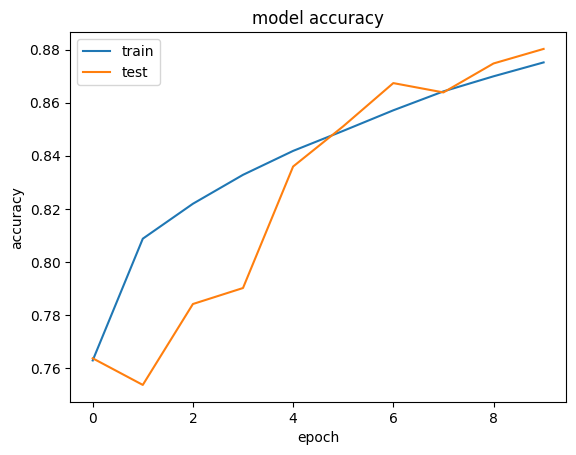

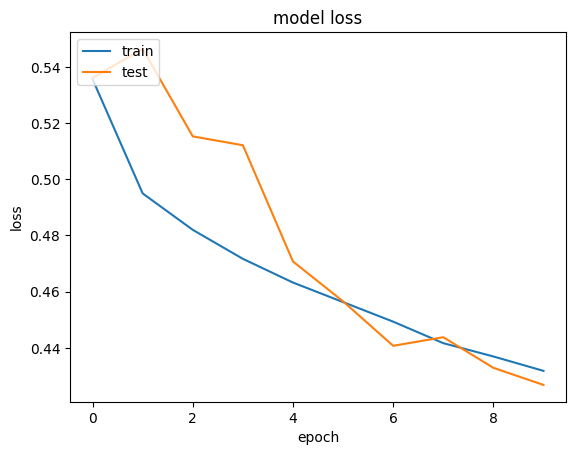

Make a few predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Binary decision logits (first 10):
 [[ 0.99948674 -0.99943805]
 [-1.          1.        ]
 [-1.          1.        ]
 [-1.          1.        ]
 [-1.          1.        ]
 [-0.8490115   0.8665339 ]
 [ 1.         -1.        ]
 [ 0.9916032  -0.99161774]
 [-0.21019942  0.22154765]
 [-1.          1.        ]]
Predictions:
 [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0] 
Ground Truth:
 [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for cross entropy loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Make a few predictions")
x = model.predict(test_set.take(1)) #batch size is 64

print("Binary decision logits (first 10):\n",x[0:10])

print("Predictions:\n",[np.argmax(x) for x in x[0:30]],'\nGround Truth:\n',[x for x in test_df.label.values[0:30]])

## Analysis of Results from Initial Model
Analysing the training versus test loss over training epochs shows it is likely optimal around 16 epochs as that is were the learning rate plateaus for both train and test loss.  Multiple runs and attempts at hyperparameter tuning were made.  Epochs set back 10 due to lenth of time to train.

## Variation of Architecture
Add a layer of convolution to determine impact.  This may allow the model to learning a higher order of features that improve classifications

In [23]:
 with tpu_strategy.scope():
    model2 = Sequential([
    Input(shape=(96, 96, 3)),  
   
    Conv2D(32, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),      
    
    Conv2D(32, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
 
    Conv2D(64, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
    
    Conv2D(64, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
 
    Conv2D(32, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
    
    # Additional Conv/pooling layer
    Conv2D(32, 3, padding='same', activation = 'relu'),
    AvgPool2D(pool_size=2, padding='same'),
 
    # build the ANN layers
    Flatten(),
    Dense(288, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='tanh')
    ])
    
    model2.compile(
     optimizer =    tf.keras.optimizers.RMSprop(
            learning_rate=0.0005,
            momentum=0.18,
        ),
        loss= keras.losses.BinaryCrossentropy(from_logits=True), # for tf v 2.15
        # loss= 'BinaryCrossentropy', # for tf v 2.13
        metrics=[ 'BinaryCrossentropy', 'accuracy']
    )

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 48, 48, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 24, 24, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 12, 12, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 6, 6, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 3, 3, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 2, 2, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 288)            │        37,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,682 (655.01 KB)

 Trainable params: 167,682 (655.01 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# define model save location
checkpoint_filepath = '/kaggle/working/model_xtralayer_cnn/'
!mkdir {checkpoint_filepath}
checkpoint_filename = 'checkpoint.model.keras'
checkpoint_fullpath = checkpoint_filepath + '' + checkpoint_filename
# checkpoint_fullpath = checkpoint_filepath # for tf v 2.13
                                           
# checkpoints = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_fullpath,
#     save_weights_only=False,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_fullpath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [25]:
# set tf functions to run eagerly
tf.config.run_functions_eagerly(True)

# fit model
history2 = model2.fit(
                    train_set,
                    epochs=10,  # keep to 10 epochs to save time
                    callbacks=[rlrop,earlyst,checkpoints],
                    validation_data = test_set
                    )


Epoch 1/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 271s 139ms/step - BinaryCrossentropy: 2.8799 - accuracy: 0.7035 - loss: 0.5791 - val_BinaryCrossentropy: 2.5304 - val_accuracy: 0.7714 - val_loss: 0.5321 - learning_rate: 5.0000e-04
Epoch 2/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 269s 138ms/step - BinaryCrossentropy: 2.0919 - accuracy: 0.8001 - loss: 0.5020 - val_BinaryCrossentropy: 2.7598 - val_accuracy: 0.7640 - val_loss: 0.5373 - learning_rate: 5.0000e-04
Epoch 3/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 270s 139ms/step - BinaryCrossentropy: 1.9576 - accuracy: 0.8168 - loss: 0.4861 - val_BinaryCrossentropy: 2.8003 - val_accuracy: 0.7483 - val_loss: 0.5477 - learning_rate: 5.0000e-04
Epoch 4/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 271s 139ms/step - BinaryCrossentropy: 1.5489 - accuracy: 0.8516 - loss: 0.4536 - val_BinaryCrossentropy: 1.3974 - val_accuracy: 0.8662 - val_loss: 0.4403 - learning_rate: 5.0000e-05
Epoch 5/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 272s 139ms/step - BinaryCrossentropy: 1.3915 - accuracy: 0.866

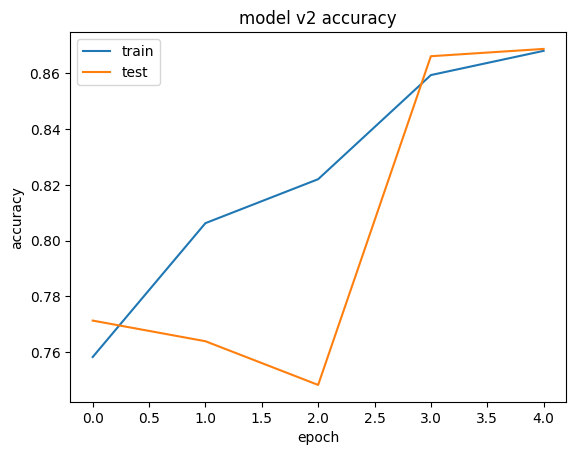

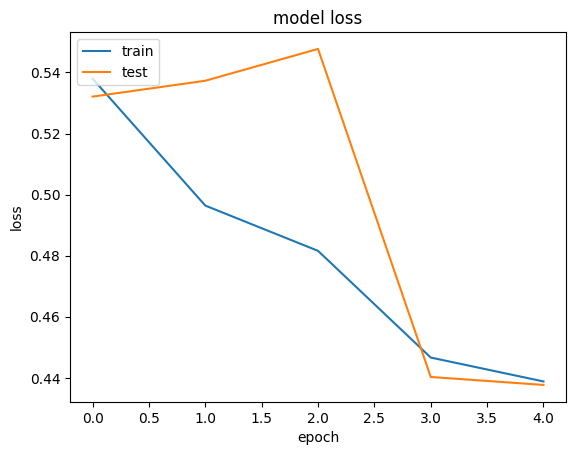

Make a few predictions with v2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Binary decision Logits v2 (firt 10):
 [[ 0.99873626 -0.9988223 ]
 [-1.          1.        ]
 [-1.          1.        ]
 [-0.9996369   0.99967223]
 [-0.9999853   0.9999867 ]
 [-0.9930862   0.9935929 ]
 [ 0.99997383 -0.9999766 ]
 [ 0.9530178  -0.9543459 ]
 [-0.23418738  0.23095761]
 [-1.          1.        ]]
Predictions v2:
 [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0] 
Ground Truth:
 [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


In [26]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model v2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Make a few predictions with v2")
x = model2.predict(test_set.take(1)) #batch of 64

print("Binary decision Logits v2 (firt 10):\n",x[0:10])

print("Predictions v2:\n",[np.argmax(x) for x in x[0:30]],'\nGround Truth:\n',[x for x in test_df.label.values[0:30]])

## Hyperparameter tuning

In [27]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = RandomSearch(
    model2,
    objective='val_accuracy',
    max_trials=3,  
    directory='cancerclassifier_tuner_dir',  
    project_name='cancerclassifier_v2'
)

tuner.search(train_set, epochs=5, validation_data=test_set, validation_steps=VA_STEPS)

# Find the best hyperparameters
best_hypers = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:\n", best_hypers)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x78c87a7a08b0> (of type <class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>)

#### Save model


In [29]:
import pickle

# Save the model
model2.save('Cancer_Image_Model2.h5')

# Save the history
with open('Cancer_Image_Model_history2.pkl', 'wb') as file:
    pickle.dump(history2.history, file)

## Conclusions
CNN results did well with only a little amount of parameter tuning and architecture adjustment.  The epochs up to 20 resulted in a model with just above 90% accuracy.  It approached 88% after just 5 epochs with the additional convolutional and pooling layer added. This was only an exploratory modeling, there are still improvements in hyperparameter tuning and more advanced CNN architectures that could be made.

#### Attributions
Source references:
HCD_SB6: https://www.kaggle.com/code/shayjohnson/hcd-sb-6

Kaggle environment setup code: https://keras.io/getting_started/

Binary Classification: https://www.kaggle.com/code/toddgardiner/binary-cancer-classifier-s-tf-tpu

GPU usage code: https://github.com/tensorflow/tensorflow/issues/64177

CuDNN and similar code: https://github.com/tensorflow/tensorflow/issues/62075

Tensflow runtime graph vs eagerly: https://www.tensorflow.org/guide/intro_to_graphs

Tensorflow versioning issues and CUDA on Kaggle: https://github.com/tensorflow/tensorflow/issues/64177